## MLP-only classification
Extract heartbeats from raw dataset and trains an MLP for classification:
- Extract all usable heartbeats of fixed length from the raw data
- Trains a MLP network with fixed parameters

In [1]:
# Importing packages
import copy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import signal
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras import initializers
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import wfdb
import os
import tensorflow as tf
warnings.filterwarnings('ignore')

In [2]:
### PARAMETERS TO SET ###

# Balance the weight of the different classes of the (unbalanced) dataset
CUSTOM_WEIGHTS = True

# Parameters for heartbeat extraction
# Number of samples to consider as the length of an heartbeat
HEARTBEAT_LENGTH = 200

# Parameters for float to integer conversion
# 16bits max and min values
INT_RANGE = 65536
INT_LOW = -32768
INT_HIGH = 32767
# Wether to convert down to 8bit or stay at 16bit
CONV_8BIT = True
print("Range: "+str(INT_RANGE)+"   MIN: "+str(INT_LOW)+"   MAX:"+str(INT_HIGH))

# Parameters for saving files
# Confusion matrix img is saved in LOG_DIR
# Model is stored in MODEL_PATH_BASE with name MODEL_NAME_BASE plus two digits
LOG_DIR = "logs/mlp_only/"
MODEL_NAME_BASE = 'mlp_only_'
MODEL_PATH_BASE = 'models/mlp_only/'

Range: 65536   MIN: -32768   MAX:32767


In [3]:
# Parameters for determinism
KERAS_SEED = 1234509876
keras.utils.set_random_seed(KERAS_SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
### Extract data from files
mitdb_list = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]

if CONV_8BIT:
    v_dataset_data = np.empty((1,HEARTBEAT_LENGTH), dtype=np.int8)
else:
    v_dataset_data = np.empty((1,HEARTBEAT_LENGTH), dtype=np.int16)

# Float dataset
v_dataset_data = np.empty((1,HEARTBEAT_LENGTH), dtype=float)
v_dataset_categ = np.empty(1, dtype=str)

v_data_min = 10.0
v_data_max = -10.0

for element in mitdb_list:
    record = wfdb.rdrecord('src/mitdb/' + str(element))
    v_data_min = np.min(record.p_signal) if np.min(record.p_signal) < v_data_min else v_data_min
    v_data_max = np.max(record.p_signal) if np.max(record.p_signal) > v_data_max else v_data_max

v_data_abs_max = np.max(np.abs([v_data_min, v_data_max]))

print("MAX: " + str(v_data_max) + "   MIN: " + str(v_data_min))
print("ABS MAX: " +str(v_data_abs_max))

for element in mitdb_list:


    print("##########")
    print("Current record: " + str(element))

    # Load all samples
    record = wfdb.rdrecord('src/mitdb/' + str(element))
    annotation = wfdb.rdann('src/mitdb/'+str(element), 'atr')

    # Convert annotations to useful ones
    # Read symbols and substitute them
    # Classes:  'N': Normal beat
    #           'S': Supraventricular premature
    #           'V': Premature ventricular contraction
    #           'F': Fusion of ventricular and normal beat
    #           'Q': Unclassifiable
    #
    # CLASSIFICATION
    # Based on the paper "A deep convolutional neural network model to classify heartbeats"
    symbol_dict = { 'N':'N', 'L':'N', 'R':'N', 'e':'N', 'j':'N',
                    'S':'S', 'A':'S', 'a':'S', 'J':'S',
                    'V':'V', 'E':'V',
                    'F':'F',
                    'Q':'Q', '/':'Q', 'f':'Q'}
    raw_ann_symbol = annotation.symbol.copy()
    raw_ann_sample = annotation.sample.copy()
    #raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else key for key in raw_ann_symbol]
    raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else 'Z' for key in raw_ann_symbol]

    # Delete non beat annotations
    if 'Z' in raw_ann_symbol:
        i_del = [i for i, x in enumerate(raw_ann_symbol) if x == 'Z']
        raw_ann_sample = np.delete(raw_ann_sample, i_del)
        raw_ann_symbol = np.delete(raw_ann_symbol, i_del)

    # Extract ECG data array
    v_data_f = record.p_signal
    v_data_f = v_data_f[:,0]

    # Convert data from float to uint16
    #v_data = np.zeros_like(v_data_f, dtype=np.int16)
    #for i in range(0, len(v_data_f)):
    #    # Offset and scale
    #    #v_data[i] = ((v_data_f[i]-v_data_min)/(v_data_max - v_data_min))*(INT_RANGE)+(INT_LOW)
    #    # Scale only
    #    v_data[i] = np.int16((v_data_f[i])/(v_data_abs_max)*(INT_HIGH))
    #    if CONV_8BIT:
    #        v_data[i] = np.int8((v_data[i] >> 8) & 0xFF)

    # If using float instead of int
    v_data = v_data_f/v_data_abs_max*INT_HIGH

    print(v_data_f)
    print(v_data)

    # Define time array (Fs:360Hz)
    v_time = np.arange(0, HEARTBEAT_LENGTH, 1, dtype=int)

    # Zeros array for x-axis
    axis_x = np.zeros_like(v_time)

    # Delete annotations for beats too close to the beginning or ending of signal
    raw_ann_symbol = raw_ann_symbol[(raw_ann_sample > (HEARTBEAT_LENGTH/2+1)) & (raw_ann_sample < (len(v_data)-(HEARTBEAT_LENGTH/2+1)))]
    raw_ann_sample = raw_ann_sample[(raw_ann_sample > (HEARTBEAT_LENGTH/2+1)) & (raw_ann_sample < (len(v_data)-(HEARTBEAT_LENGTH/2+1)))]

    print(raw_ann_symbol)
    print(raw_ann_sample)
    print(len(raw_ann_symbol))
    print(len(raw_ann_sample))
    
    # Divide signal in single heartbeats
    v_total_data = np.zeros(shape=(len(raw_ann_symbol),HEARTBEAT_LENGTH))
    v_total_categ = np.empty(len(raw_ann_symbol), dtype=str)
    for i in range(0, len(v_total_data)-1):
        v_total_data[i,:] = v_data[(raw_ann_sample[i] - int(HEARTBEAT_LENGTH/2)) : (raw_ann_sample[i] + int(HEARTBEAT_LENGTH/2))]
        v_total_categ[i] = raw_ann_symbol[i]
        #print(v_total_data[i,:])

    # Delete empty data
    v_total_data = v_total_data[v_total_categ != '']
    v_total_categ = v_total_categ[v_total_categ != '']

    # Copy results to dataset variables
    v_dataset_data = np.append(v_dataset_data, v_total_data, axis=0)
    v_dataset_categ = np.append(v_dataset_categ, v_total_categ)

# Delete first element (empty)
v_dataset_data = v_dataset_data[1:,:]
v_dataset_categ = v_dataset_categ[1:]

print(v_dataset_categ)
print(v_dataset_data)
    

MAX: 5.115   MIN: -5.12
ABS MAX: 5.12
##########
Current record: 100
[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
[ -927.97167969  -927.97167969  -927.97167969 ... -4319.86816406
 -4895.85058594 -8191.75      ]
['N' 'N' 'N' ... 'N' 'N' 'N']
[   370    662    946 ... 649232 649484 649734]
2271
2271
##########
Current record: 101
[-0.345 -0.345 -0.345 ... -0.295 -0.29   0.   ]
[-2207.93261719 -2207.93261719 -2207.93261719 ... -1887.94238281
 -1855.94335937     0.        ]
['N' 'N' 'N' ... 'N' 'N' 'N']
[   396    711   1032 ... 649004 649372 649751]
1864
1864
##########
Current record: 102
[-0.2   -0.2   -0.2   ... -0.17  -0.195  0.   ]
[-1279.9609375  -1279.9609375  -1279.9609375  ... -1087.96679688
 -1247.96191406     0.        ]
['Q' 'Q' 'Q' ... 'Q' 'Q' 'Q']
[   136    410    697 ... 649244 649553 649852]
2187
2187
##########
Current record: 103
[-0.375 -0.375 -0.375 ... -0.235 -0.245  0.   ]
[-2399.92675781 -2399.92675781 -2399.92675781 ... -1503.95410156
 -1567.95214844     0.    

In [5]:
# Backup dataset to other variable
v_dataset_data_bk = np.copy(v_dataset_data)
v_dataset_categ_bk = np.copy(v_dataset_categ)

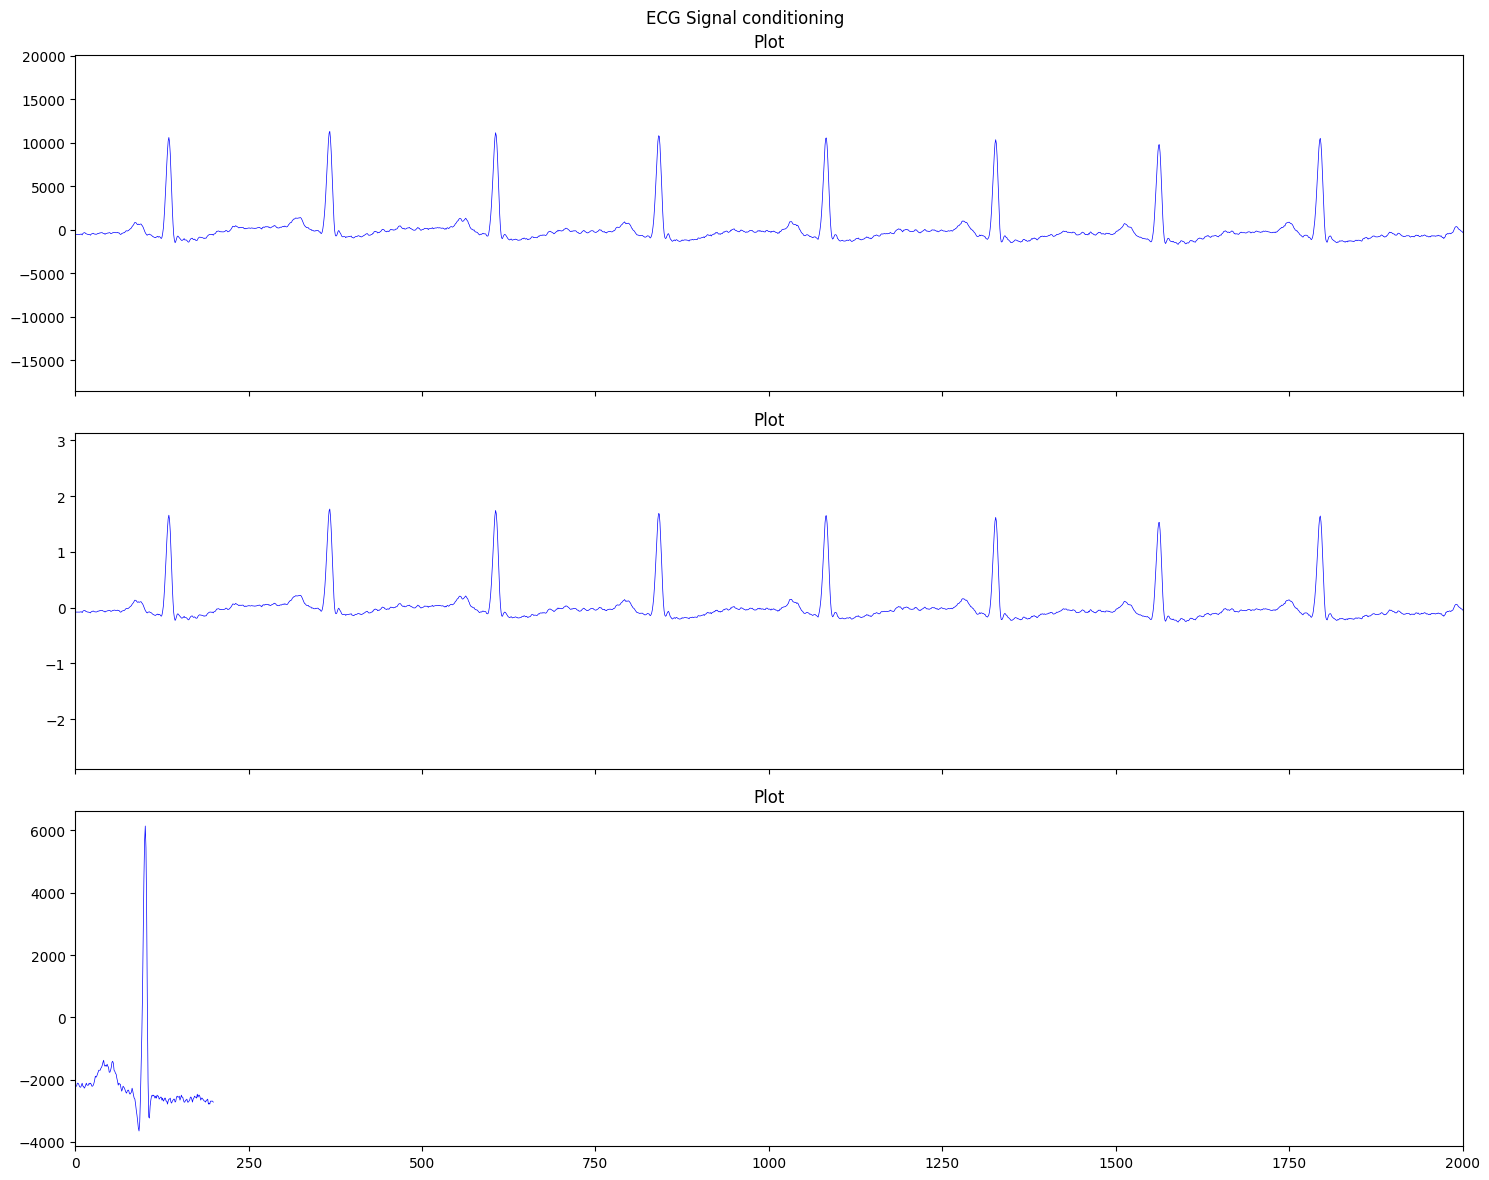

In [17]:
# Plotting window
X_MIN = 0
X_MAX = 2000
N_ROW = 3
N_COL = 1
PLOT_LOW = INT_LOW
PLOT_HIGH = INT_HIGH

if CONV_8BIT:
    PLOT_LOW = -128
    PLOT_HIGH = 127

n = 0
# Create plots
fig, axs = plt.subplots(N_ROW, N_COL, sharex=True)
fig.set_size_inches(15, 4*N_ROW)
fig.suptitle("ECG Signal conditioning")
axs[n].set_xlim(X_MIN, X_MAX)

# First plot
axs[n].title.set_text('Plot')
axs[n].plot(v_data, 'b', label="raw data", linewidth=0.5)
#axs[n].set_ylim([PLOT_LOW, PLOT_HIGH])
n += 1

# First plot
axs[n].title.set_text('Plot')
axs[n].plot(v_data_f, 'b', label="raw data", linewidth=0.5)
#axs[n].set_ylim([v_data_min, v_data_max])
n += 1

# First plot
axs[n].title.set_text('Plot')
axs[n].plot(v_dataset_data[1], 'b', label="raw data", linewidth=0.5)
n += 1


# First plot
#axs[n].title.set_text('Plot')
#axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
#axs[n].plot(v_time, v_dataset_data[n], 'b', label="raw data", linewidth=0.5)
#axs[n].legend()
#n += 1

# First plot
#axs[n].title.set_text('Plot')
#axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
#axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
#axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
#axs[n].plot(v_peaks_P_time, v_peaks_P_data, 'bo', label="P peaks", linewidth=0.5)
#axs[n].plot(v_peaks_T_time, v_peaks_T_data, 'ro', label="T peaks", linewidth=0.5)
#axs[n].legend()
#n += 1

plt.tight_layout()
plt.show()

In [7]:
# Copy from backup data
dataset_categ = np.copy(v_dataset_categ_bk)
dataset_data = np.copy(v_dataset_data_bk)

# Convert symbols to numbers
category_dict = {   'N':0,
                    'S':1,
                    'V':2,
                    'F':3,
                    'Q':4}
dataset_categ = [category_dict[key] if key in category_dict else 'Z' for key in dataset_categ]

# Divide data into sets
DATA_SPLIT = 0.2
SEED = 1029384756
set_train, x_valid, target_train, y_valid = train_test_split(dataset_data, dataset_categ, test_size=DATA_SPLIT, random_state=SEED)
x_train, x_test, y_train, y_test = train_test_split(set_train, target_train, test_size=DATA_SPLIT, random_state=SEED)

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_valid=to_categorical(y_valid)

In [8]:
# Calculate cutom weights for training
tot_y_train = np.sum(y_train, axis=0)
tot_y_test = np.sum(y_test, axis=0)
tot_y_valid = np.sum(y_valid, axis=0)
tot_y_all = tot_y_train + tot_y_test + tot_y_valid

print(tot_y_train)
print(tot_y_test)
print(tot_y_valid)
print(tot_y_all)

max_class = np.max(tot_y_train)
#max_class = np.sum(tot_y_train)

custom_weights = {  0: int(max_class/tot_y_train[0]),
                    1: int(max_class/tot_y_train[1]),
                    2: int(max_class/tot_y_train[2]),
                    3: int(max_class/tot_y_train[3]),
                    4: int(max_class/tot_y_train[4])}

print(custom_weights)

[58011.  1800.  4595.   505.  5113.]
[14488.   430.  1160.   127.  1302.]
[18062.   549.  1480.   170.  1622.]
[90561.  2779.  7235.   802.  8037.]
{0: 1, 1: 32, 2: 12, 3: 114, 4: 11}


In [98]:
# Define NN structure
NEURONS = 30
LEARNING_RATE = 0.00001
model = Sequential([
    Input(shape=((x_train[0].shape[0],1)), name='inputs_nn'),
    Flatten(),    
    # Custom initial weights for deterministic behavior
    Dense(NEURONS, activation='relu', name="dense_1", kernel_initializer=initializers.GlorotUniform(seed=KERAS_SEED), bias_initializer='zeros'),
    Dense(5, activation='softmax', name='main_output', kernel_initializer=initializers.GlorotUniform(seed=KERAS_SEED), bias_initializer='zeros') 
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         6,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,185 (24.16 KB)

 Trainable params: 6,185 (24.16 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Training parameters
EPOCH_NUM = 150
BATCH_SIZE = 64

# Train model
if (CUSTOM_WEIGHTS):
    history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid), class_weight=custom_weights)
else:
    history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid))


Epoch 1/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7609 - loss: 20558.2070 - val_accuracy: 0.4149 - val_loss: 929.1068
Epoch 2/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3658 - loss: 5162.8013 - val_accuracy: 0.3214 - val_loss: 676.9319
Epoch 3/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3397 - loss: 2692.5276 - val_accuracy: 0.3593 - val_loss: 575.9307
Epoch 4/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3723 - loss: 2139.7681 - val_accuracy: 0.3876 - val_loss: 500.8598
Epoch 5/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4017 - loss: 1825.0093 - val_accuracy: 0.4302 - val_loss: 424.7631
Epoch 6/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4315 - loss: 1598.0083 - val_accuracy: 0.4506 - val_loss: 382.0143
Epoch 7/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4552 - loss: 1424.5452 - val_accuracy: 0.4716 - val_loss: 338.4781
Epoch 8/150
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1

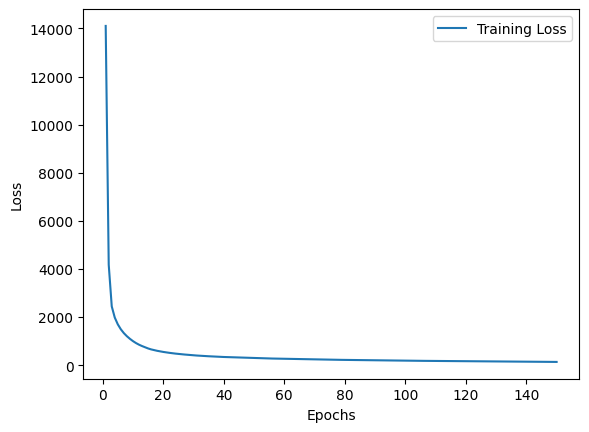

In [100]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0, 10)
plt.legend()

plt.show()

In [101]:
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test_pred = np.argmax(y_test, axis=1)


# Create confusion matrix and normalize it over predicted (columns)
#result = confusion_matrix(y_test_pred, y_prediction , normalize='pred')
result = confusion_matrix(y_test_pred, y_prediction , normalize='true')
#result = confusion_matrix(y_test_pred, y_prediction , normalize='all')
#result = confusion_matrix(y_test_pred, y_prediction)
classes = [0,1,2,3,4]
result_norm = np.around(result, 3)
#result_norm = result
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion matrix
       0      1      2      3      4
0  0.799  0.092  0.040  0.054  0.016
1  0.172  0.742  0.023  0.023  0.040
2  0.029  0.015  0.912  0.028  0.016
3  0.118  0.008  0.087  0.780  0.008
4  0.022  0.020  0.012  0.010  0.936

Average accuracy
0.8337015831771037


In [102]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(y_test_pred, y_prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      0.80      0.88     14488
     class 1       0.19      0.74      0.30       430
     class 2       0.63      0.91      0.75      1160
     class 3       0.11      0.78      0.19       127
     class 4       0.82      0.94      0.87      1302

    accuracy                           0.81     17507
   macro avg       0.55      0.83      0.60     17507
weighted avg       0.92      0.81      0.85     17507



In [103]:
model_num = 0
#while os.path.exists(MODEL_PATH_BASE + MODEL_NAME_BASE + "%s.keras" % f"{model_num:02}"):
#    model_num += 1
log_dir = LOG_DIR
#model_name = MODEL_NAME_BASE+ str(f"{model_num:02}")
model_name = MODEL_NAME_BASE+ str(f"{NEURONS:02}")
model_path = MODEL_PATH_BASE + model_name + '.keras'
model.name = model_name
#model.save(model_path)

In [104]:
model_name = "mlp_only_float_n"+str(f"{NEURONS:02}")

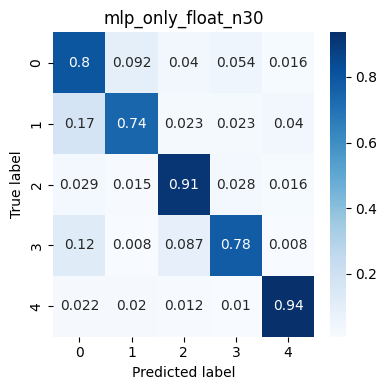

In [105]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()